In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 9) #set figsize for all

In [2]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 'Timezone', 'DST', 'Tz', 'type', 'source']
airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
                     names=airport_col, index_col=0)
airports.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [3]:
route_col = ['Airline', 'Airline_ID', 'Source', 'Source_ID', 'Dest', 'Dest_ID', 'Codeshare', 'Stops', 'equipment']
routes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
                     names=route_col, index_col=0)
routes.head()

,Airline_ID,Source,Source_ID,Dest,Dest_ID,Codeshare,Stops,equipment
Airline,,,,,,,,
2B,410,AER,2965,KZN,2990,NaN,0,CR2
2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2B,410,CEK,2968,KZN,2990,NaN,0,CR2
2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [4]:
airports['Country'].value_counts().sort_values(ascending=False)

United States              1512
Canada                      430
Australia                   334
Brazil                      264
Russia                      264
                           ... 
Niue                          1
Gibraltar                     1
Palau                         1
Cocos (Keeling) Islands       1
Tuvalu                        1
Name: Country, Length: 237, dtype: int64

In [5]:
# Get Vietnam airport keys
airport_vn_keys = airports[airports['Country'] == 'Vietnam']['IATA'].unique().tolist() #list
print("Vietnamese airport IATAs: {0}".format(airport_vn_keys))
route_vn = routes[(routes['Source'].isin(airport_vn_keys)) | (routes['Dest'].isin(airport_vn_keys))] #df

# Group by unique routes since some codeshared airlines are listed multiple times
# this gives us the edge weight by airline count for each airport
route_vn =  pd.DataFrame(route_vn.groupby(['Source', 'Dest']).size().reset_index(name='airline_count'))
print("There are {0} unique flight routes in and out of Vietnam.".format(len(route_vn)))

Vietnamese airport IATAs: ['DAD', '\\N', 'HAN', 'NHA', 'HUI', 'PQC', 'SGN', 'DLI', 'VDH', 'VKG', 'CAH', 'VCL', 'TBB', 'BMV', 'HPH', 'CXR', 'VCS', 'VCA', 'DIN', 'UIH', 'PXU', 'VII', 'PHA', 'SQH']
There are 244 unique flight routes in and out of Vietnam.


In [6]:
# Get flight count in and out of an airport, counting both ways
count = route_vn['Source'].append(route_vn['Dest']).value_counts()
count = pd.DataFrame({'IATA':count.index, 'flight_count':count.values})

# Merge in
airport_vn_foreign_keys = route_vn['Source'].append(route_vn['Dest']).unique().tolist() #list
airport_vn_foreign = pd.merge(airports[airports['IATA'].isin(airport_vn_foreign_keys)], 
                              count[count['IATA'].isin(airport_vn_foreign_keys)], 
                              on=['IATA'], how='outer') #outer full join

In [7]:
# Assign nodes, edge df, and node df
edge_df = route_vn
nodes   = airport_vn_foreign_keys
node_df = airport_vn_foreign[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long', 'flight_count']]

## Matplotlib

In [8]:
# We start from a blank nx graph, this time with Long, Lat as node position
G = nx.Graph()

for node in nodes:
    G.add_node(node)

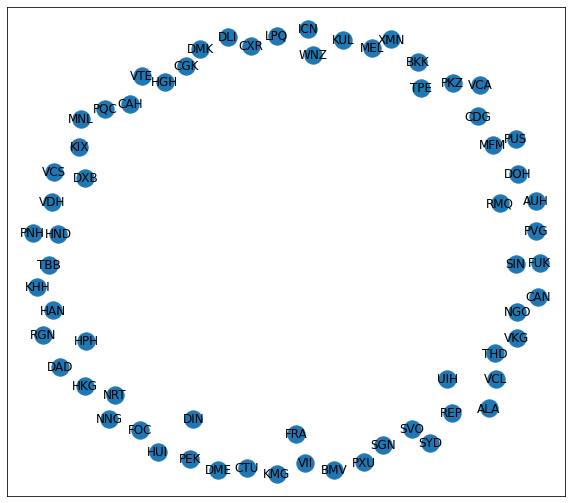

In [9]:
# At every step, we can draw graph by:
nx.draw_networkx(G)
plt.show()

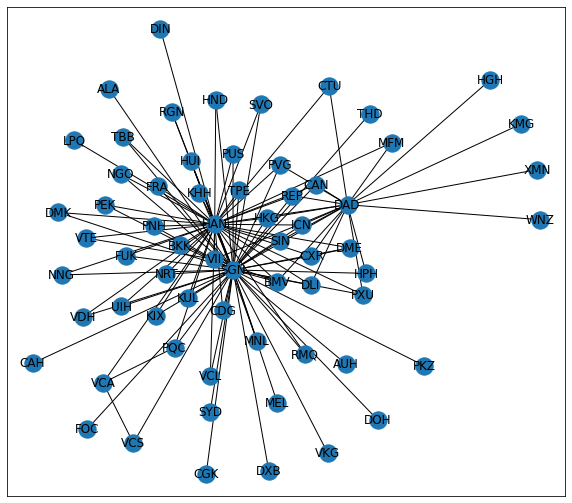

In [10]:
for index, row in edge_df.iterrows():
    G.add_edge(row['Source'], row['Dest'], weight=row['airline_count'])

nx.draw_networkx(G)
plt.show()

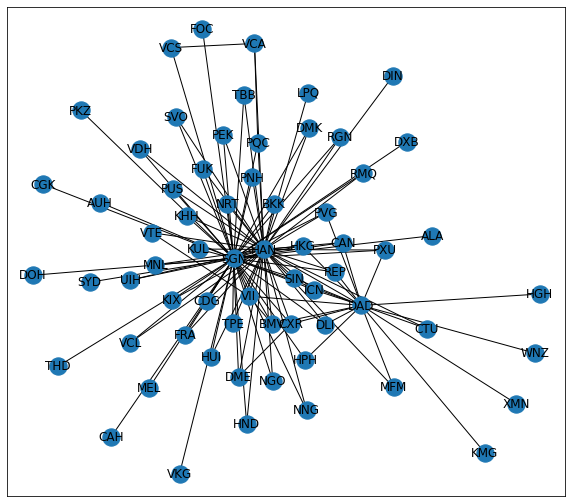

In [11]:
# Get node position dict
x, y = node_df['Long'].values, node_df['Lat'].values

pos_dict = {}
for index, iata in enumerate(node_df['IATA']):
    pos_dict[iata] = (x[index], y[index])
    
for iata, coordinate in pos_dict.items():
    G.nodes[iata]['pos'] = coordinate
    
nx.draw_networkx(G)
plt.show()

In [12]:
# ^We could have gotten here through this shorter code:
# G = nx.from_pandas_edgelist(edge_df, pos=pos_dict, source = 'Source', target = 'Dest', edge_attr='airline_count')

# nx.draw_networkx(G)
# plt.show()

## Plotly and Mapbox

In [25]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

# Add nodes
fig.add_trace(go.Scattermapbox(
    lat=node_df['Lat'],
    lon=node_df['Long'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=node_df['flight_count'],
        sizeref=0.1,
        sizemode="area",
    ),
    text=node_df['Name'],
))




fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=16,
            lon=107
        ),
        pitch=0,
        zoom=5
    )
)

fig.show()